## Data Conditioning


#### Goal of this section is to condition the data by performing some transformations.

In [1]:
install.packages("mlbench")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [2]:
library(mlbench)
library(dplyr, warn.conflicts = FALSE)
library(moments)
library(ggplot2)
library(repr)

In [ ]:
data("BostonHousing")

In [14]:
dim(BostonHousing)

[1] 506  14

### Check for missing data and handle it.


Notice below that we do not have any missing data

In [4]:
BostonHousing[!complete.cases(BostonHousing),]

crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv


### Prepare data for analysing

Let's separate features from the target.

Note that we can include the categorical column chas in the aggregation as chas is a binary values column with 0 or 1 as values. We just need to convert the column's data type from factor to integer, we can perform computations on it like a numeric column.

In [5]:
bostonhousing_features <- BostonHousing[1:13]
bostonhousing_features$chas = as.numeric(as.character(bostonhousing_features$chas))
head(bostonhousing_features)

crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33
0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21


### Let's compute stats for the complete population

In [6]:
stats = data.frame(feature=colnames(bostonhousing_features))
stats['mean_'] = sapply(bostonhousing_features, mean)
stats['sd_'] = sapply(bostonhousing_features, sd)
stats['skewness_'] = sapply(bostonhousing_features, skewness)
stats['kurtosis_'] = sapply(bostonhousing_features, kurtosis)
stats

feature,mean_,sd_,skewness_,kurtosis_
crim,3.61352356,8.6015451,5.2076524,39.752786
zn,11.36363636,23.3224530,2.2190631,6.979949
indus,11.13677866,6.8603529,0.2941463,1.766782
chas,0.06916996,0.2539940,3.3957993,12.531453
nox,0.55469506,0.1158777,0.7271442,2.924136
rm,6.28463439,0.7026171,0.4024147,4.861027
age,68.57490119,28.1488614,-0.5971856,2.029986
dis,3.79504269,2.1057101,1.0087788,3.471299
rad,9.54940711,8.7072594,1.0018335,2.129479
tax,408.23715415,168.5371161,0.6679683,1.857015


#### Observations based on population stats above:

- Comparing the mean across the features, it seems that some features show much lower mean e.g. chas(0.069), nox(0.55), while some others show a much higher mean e.g., tax(408), b(356).
  **We can compare features with different scale by normalizing the data.**

- Comparing the skew across features, age, ptratio & b have a negative skew while the rest of the features have a positive skew, some more skewed than others. Crim has the highest positive skew. 
  **We can deskew by taking log of the data.**


### Normalize/Scale the data

To compare features with different data scales, let's normalize/standardize to scale the data.

In [7]:
bostonhousing_sc_features = data.frame(scale(bostonhousing_features))

In [8]:
stats_scaled = data.frame(feature=colnames(bostonhousing_sc_features))
stats_scaled['mean_'] = sapply(bostonhousing_sc_features, mean)
stats_scaled['sd_'] = sapply(bostonhousing_sc_features, sd)
stats_scaled['skewness_'] = sapply(bostonhousing_sc_features, skewness)
stats_scaled['kurtosis_'] = sapply(bostonhousing_sc_features, kurtosis)
stats_scaled

feature,mean_,sd_,skewness_,kurtosis_
crim,-7.202981e-18,1,5.2076524,39.752786
zn,2.282481e-17,1,2.2190631,6.979949
indus,1.595296e-17,1,0.2941463,1.766782
chas,-3.544441e-18,1,3.3957993,12.531453
nox,-2.150022e-16,1,0.7271442,2.924136
rm,-1.056462e-16,1,0.4024147,4.861027
age,-1.643357e-16,1,-0.5971856,2.029986
dis,1.153079e-16,1,1.0087788,3.471299
rad,4.799652e-17,1,1.0018335,2.129479
tax,2.024415e-17,1,0.6679683,1.857015


#### Notice that normalizing/scaling the data makes the mean 0, and the std deviation 1. It has no effect on the skewness or kurtosis.


#### Let's plot the distributions of original vs. scaled stats

In [9]:
source('multiplot.r')

In [21]:
options(repr.plot.width=10, repr.plot.height=2) 
original_v_scaled <- function (feature) {
    original_feature <- as.vector(bostonhousing_features[[feature]])
    scaled_feature <- as.vector(bostonhousing_sc_features[[feature]])
    p1 <- qplot(original_feature, geom="histogram", bins=200, alpha=I(.4),)+
        geom_vline(aes(xintercept=mean(original_feature)), color="red", linetype="dashed", size=1)+
        geom_vline(aes(xintercept=median(original_feature)), color="blue", linetype="dashed", size=1)+
        ggtitle(paste("Original Distribution of", feature))      
    p2 <- qplot(scaled_feature, geom="histogram", bins=400, alpha=I(.4),)+
        geom_vline(aes(xintercept=mean(scaled_feature)), color="red", linetype="dashed", size=1)+
        geom_vline(aes(xintercept=median(scaled_feature)), color="blue", linetype="dashed", size=1)  +
        ggtitle(paste("Scaled Distribution of", feature)) 
        
    multiplot(p1, p2, cols=2)
}


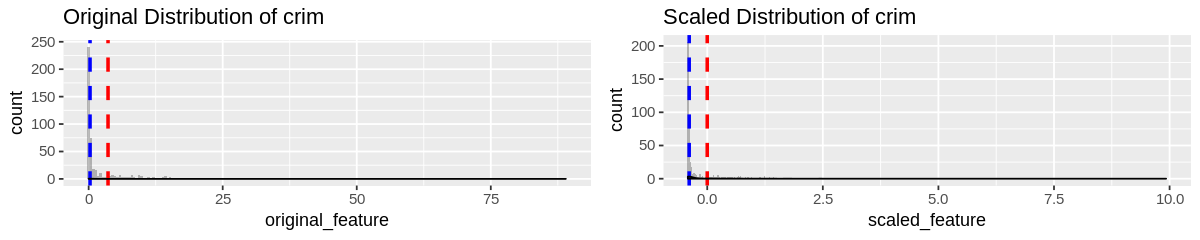

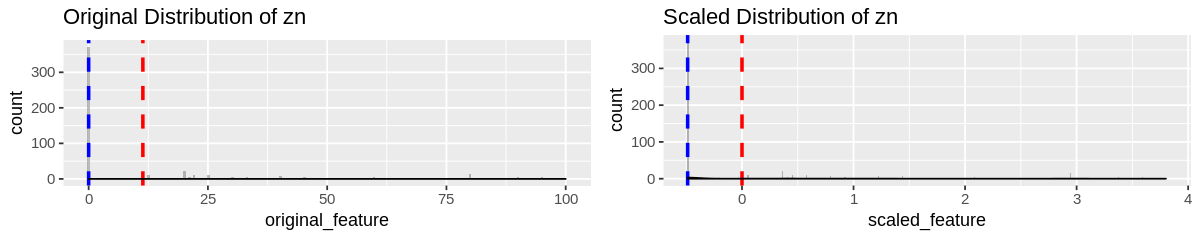

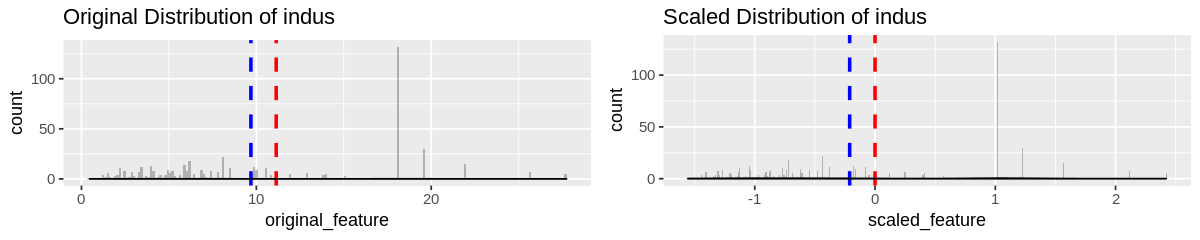

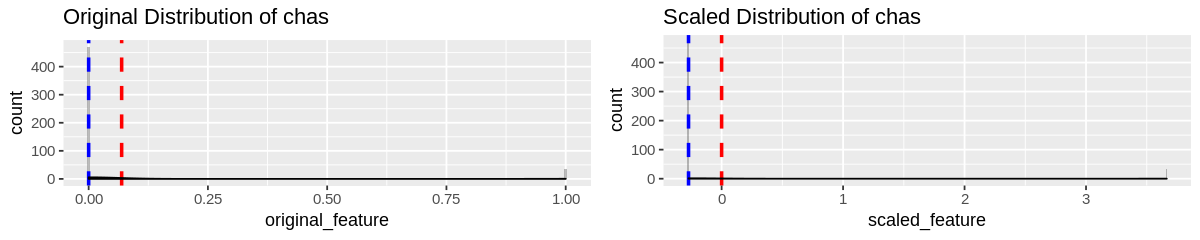

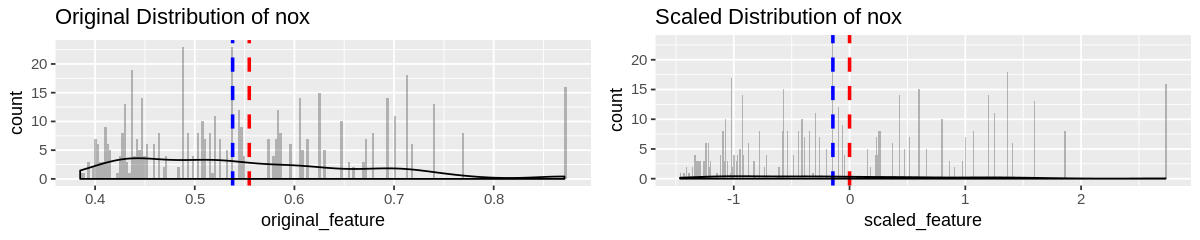

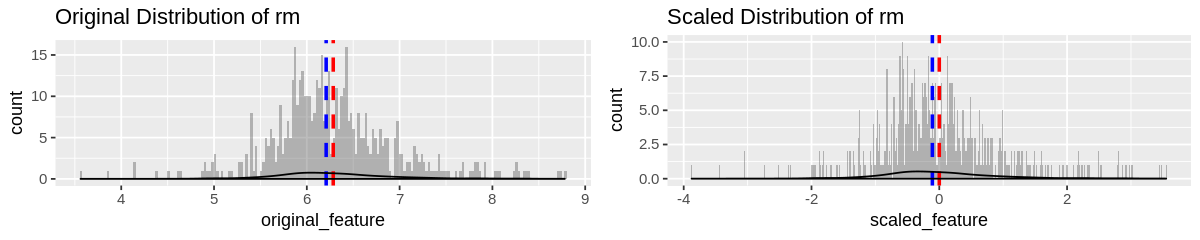

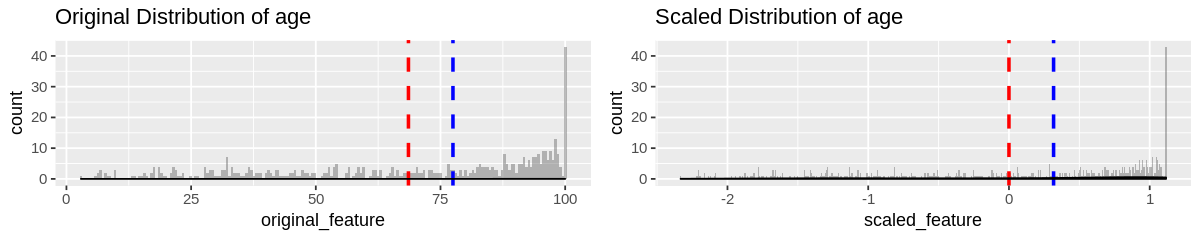

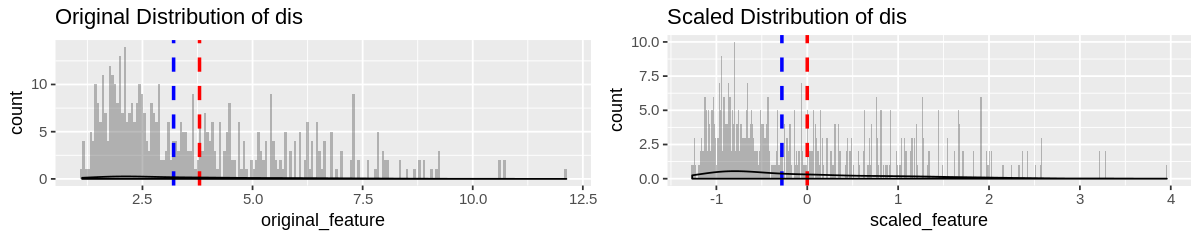

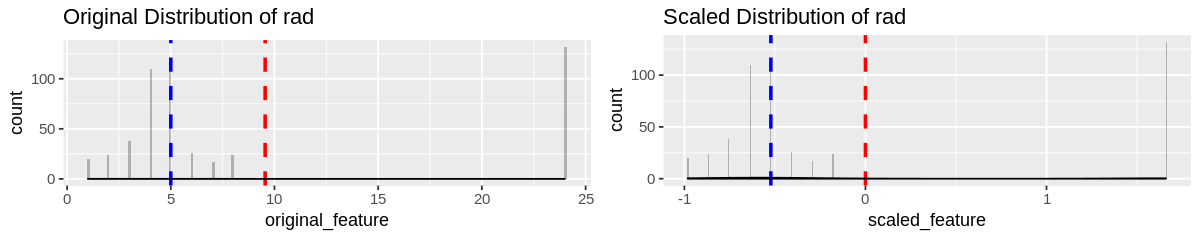

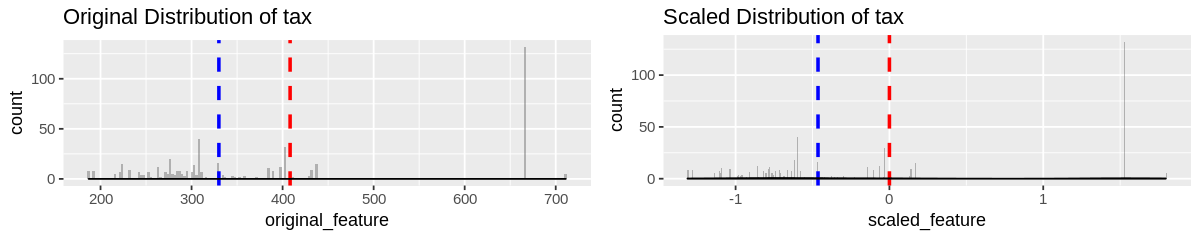

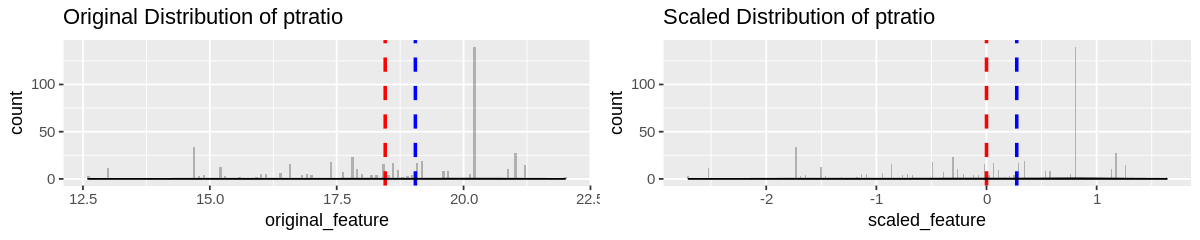

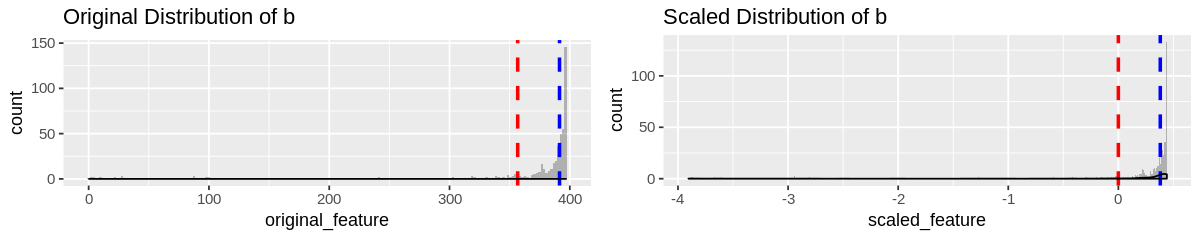

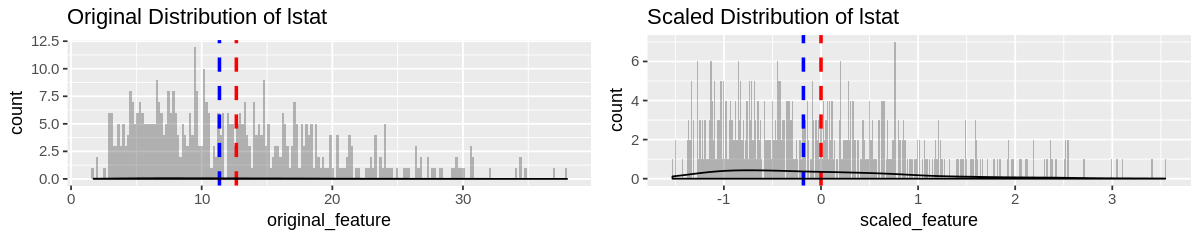

In [22]:
original_v_scaled('crim')
original_v_scaled('zn')
original_v_scaled('indus')
original_v_scaled('chas')
original_v_scaled('nox')
original_v_scaled('rm')
original_v_scaled('age')
original_v_scaled('dis')
original_v_scaled('rad')
original_v_scaled('tax')
original_v_scaled('ptratio')
original_v_scaled('b')
original_v_scaled('lstat')

#### Observations:

The red line is the mean and the blue line the median.

Comparing the scaled data plot to the original data plot, we can see that scaling does not change the data, it just makes the mean 0 and standard deviation 1 and thus just changes the scale of the distribution axis.

### Deskew by taking log of the data


Most of the time, we can deskew the data by taking the log of the data. 

Let's take log of the data before scaling it and check if that deskews the data.

In [17]:
bostonhousing_log_features = log(bostonhousing_features)
bostonhousing_log_sc_features = data.frame(scale(bostonhousing_log_features))

In [18]:
skewness_ = data.frame(feature=colnames(bostonhousing_features))
skewness_['skew_'] = sapply(bostonhousing_features, skewness)
skewness_['skew_sc'] = sapply(bostonhousing_sc_features, skewness)
skewness_['skew_log_'] = sapply(bostonhousing_log_features, skewness)
skewness_['skew_log_sc'] = sapply(bostonhousing_log_sc_features, skewness)
skewness_

feature,skew_,skew_sc,skew_log_,skew_log_sc
crim,5.2076524,5.2076524,0.4047301,0.4047301
zn,2.2190631,2.2190631,NaN,NaN
indus,0.2941463,0.2941463,-0.6412176,-0.6412176
chas,3.3957993,3.3957993,NaN,NaN
nox,0.7271442,0.7271442,0.3567181,0.3567181
rm,0.4024147,0.4024147,-0.2937892,-0.2937892
age,-0.5971856,-0.5971856,-1.6706836,-1.6706836
dis,1.0087788,1.0087788,0.1522770,0.1522770
rad,1.0018335,1.0018335,0.2857667,0.2857667
tax,0.6679683,0.6679683,0.3295759,0.3295759


#### Observations:

Features, n and chas show NaN for skew on log of the data. This is because of instances with 0's in zn and chas and R's log function return NaNs for 0. We can fix this by adding the smallest number across all features before we perform the log. Let's try it and see if it fixes the problem.

#### Add a very small number to values of features zn and chas and compute the log of data

In [26]:
bostonhousing_features_m <- bostonhousing_features
bostonhousing_features_m$zn = bostonhousing_features_m$zn + .0001 
bostonhousing_features_m$chas = bostonhousing_features_m$chas + .0001 

bostonhousing_log_features = log(bostonhousing_features_m)
bostonhousing_log_sc_features = data.frame(scale(bostonhousing_log_features))

skewness_ = data.frame(feature=colnames(bostonhousing_features_m))
skewness_['skew_'] = sapply(bostonhousing_features_m, skewness)
skewness_['skew_sc'] = sapply(bostonhousing_sc_features, skewness)
skewness_['skew_log_'] = sapply(bostonhousing_log_features, skewness)
skewness_['skew_log_sc'] = sapply(bostonhousing_log_sc_features, skewness)
skewness_

feature,skew_,skew_sc,skew_log_,skew_log_sc
crim,5.2076524,5.2076524,0.4047301,0.4047301
zn,2.2190631,2.2190631,1.0768716,1.0768716
indus,0.2941463,0.2941463,-0.6412176,-0.6412176
chas,3.3957993,3.3957993,3.3957993,3.3957993
nox,0.7271442,0.7271442,0.3567181,0.3567181
rm,0.4024147,0.4024147,-0.2937892,-0.2937892
age,-0.5971856,-0.5971856,-1.6706836,-1.6706836
dis,1.0087788,1.0087788,0.1522770,0.1522770
rad,1.0018335,1.0018335,0.2857667,0.2857667
tax,0.6679683,0.6679683,0.3295759,0.3295759


#### Observations:

- Yay! Looks like adding a small number of 0.001 to zn and chass helped fix the problem of NaNs :)

- Notice that skew and skew_sc (skew after scaling) are the same as scaling does not change the skew.

- After taking log, skew_log_ is close to zero for most features. For some features like zn, chas, age, ptratio, b - there is still some minimal skew. 

- skew_log_ (skew after log of data) is the same as skew_log_sc (skew after log and scale) as scaling does not change the skew. 

#### Let's plot to visualize it

In [27]:
original_v_scaled_v_log <- function (feature) {
    original_feature <- as.vector(bostonhousing_features_m[[feature]])
    scaled_feature <- as.vector(bostonhousing_sc_features[[feature]])
    log_feature <- as.vector(bostonhousing_log_features[[feature]])
    log_scaled_feature <- as.vector(bostonhousing_log_sc_features[[feature]])
    p1 <- qplot(original_feature, geom="histogram", bins=200, alpha=I(.4),)+
        geom_vline(aes(xintercept=mean(original_feature)), color="red", linetype="dashed", size=1)+
        geom_vline(aes(xintercept=median(original_feature)), color="blue", linetype="dashed", size=1)+
        ggtitle(paste("Original Distribution of", feature))
    p2 <- qplot(scaled_feature, geom="histogram", bins=200, alpha=I(.4),)+
        geom_vline(aes(xintercept=mean(scaled_feature)), color="red", linetype="dashed", size=1)+
        geom_vline(aes(xintercept=median(scaled_feature)), color="blue", linetype="dashed", size=1)  +
        ggtitle(paste("Scaled Distribution of", feature))  
    p3 <- qplot(log_feature, geom="histogram", bins=200, alpha=I(.4),)+
        geom_vline(aes(xintercept=mean(log_feature)), color="red", linetype="dashed", size=1)+
        geom_vline(aes(xintercept=median(log_feature)), color="blue", linetype="dashed", size=1)+
        ggtitle(paste("Log Distribution of", feature))
    p4 <- qplot(log_scaled_feature, geom="histogram", bins=200, alpha=I(.4),)+
        geom_vline(aes(xintercept=mean(log_scaled_feature)), color="red", linetype="dashed", size=1)+
        geom_vline(aes(xintercept=median(log_scaled_feature)), color="blue", linetype="dashed", size=1)  +
        ggtitle(paste("Log Scaled Distribution of", feature))  
    multiplot(p1, p2, p3, p4, cols=4)
}

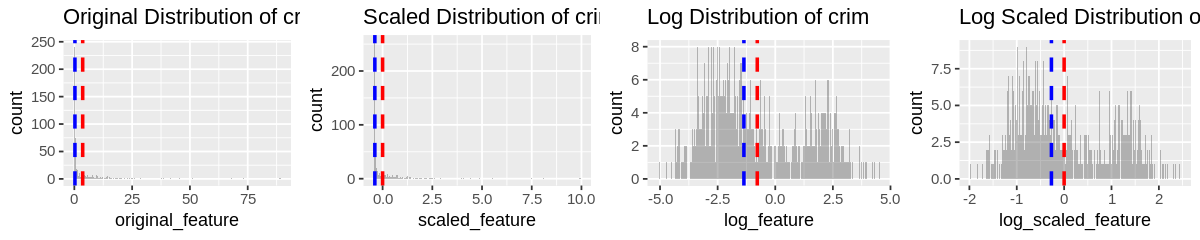

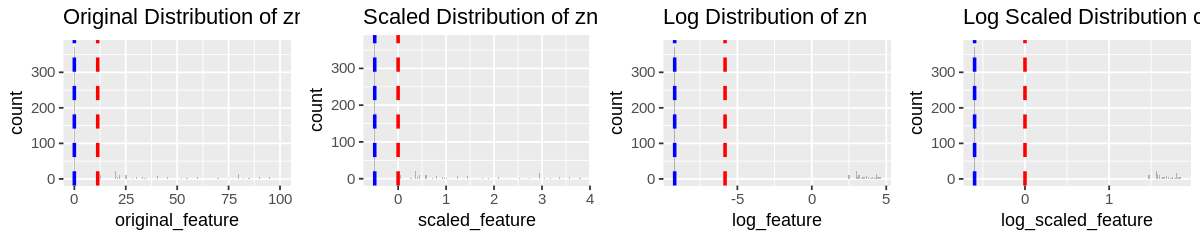

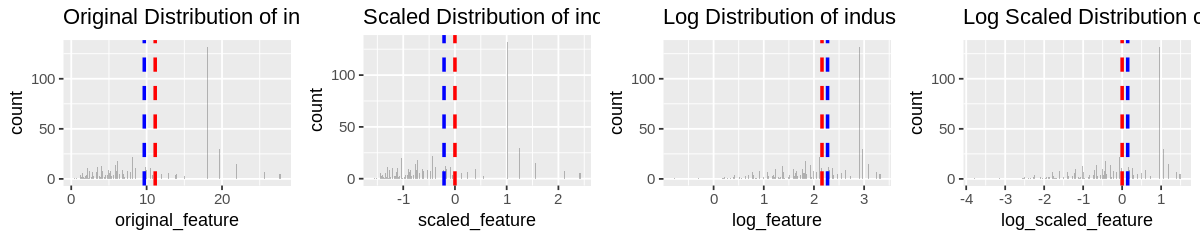

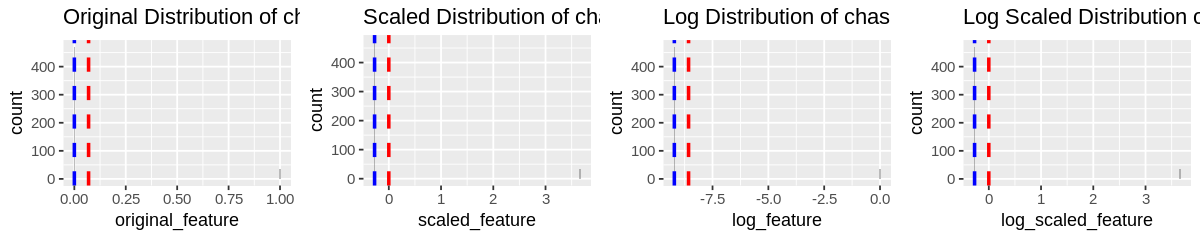

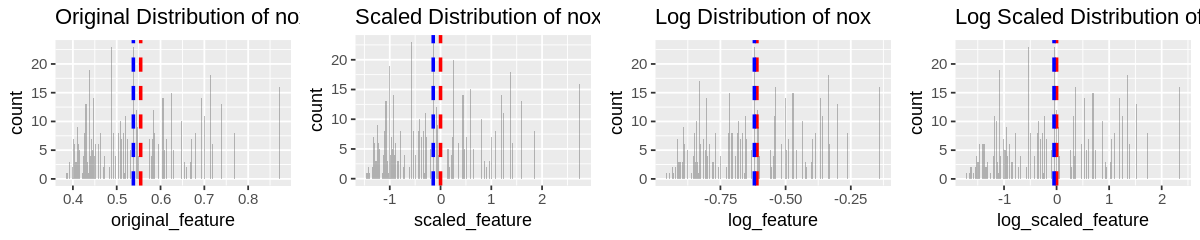

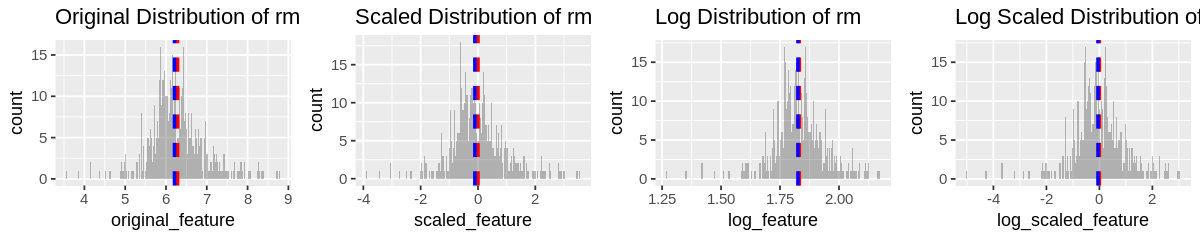

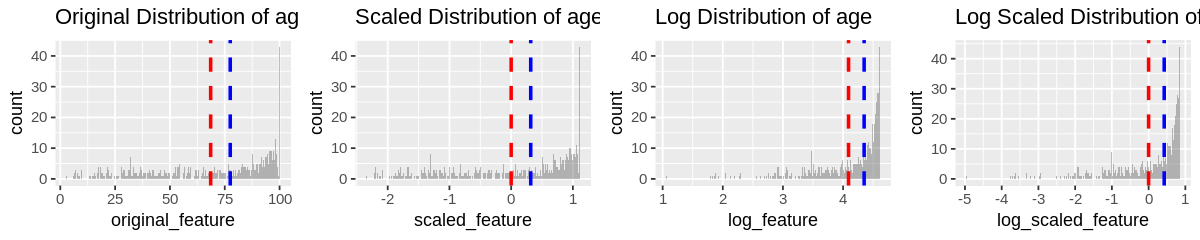

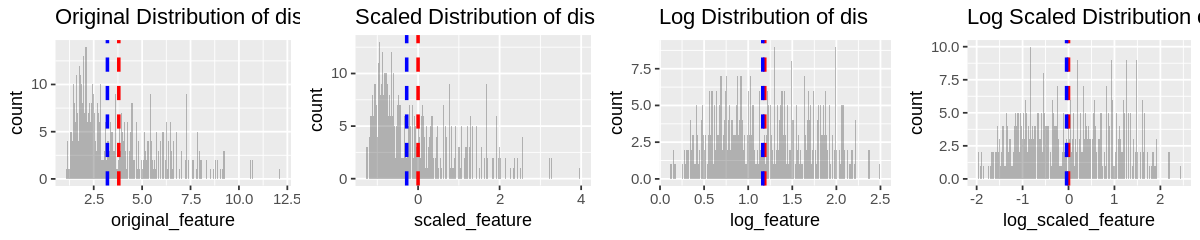

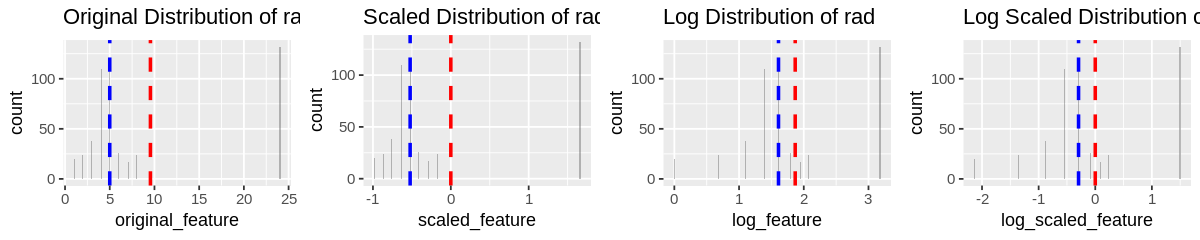

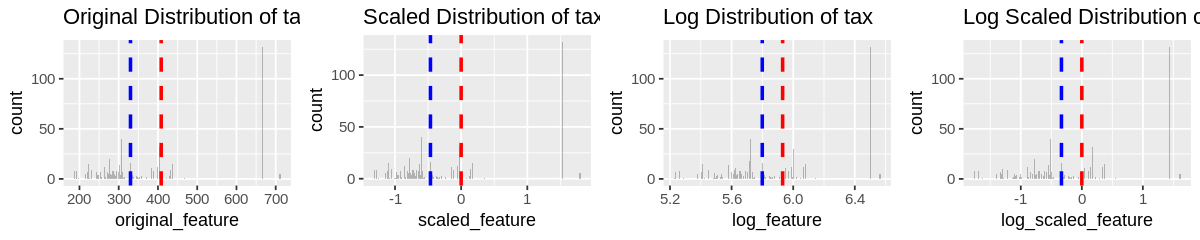

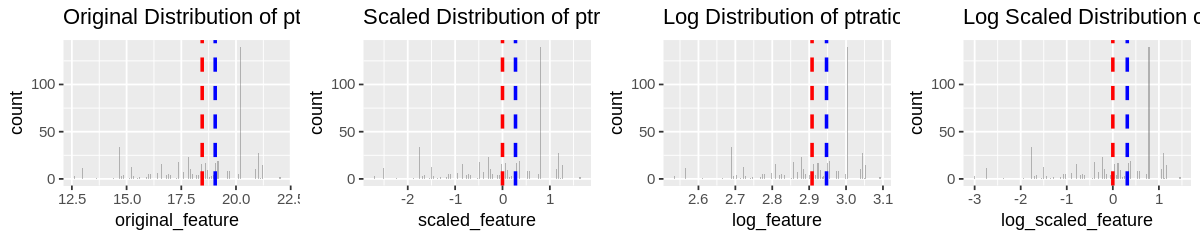

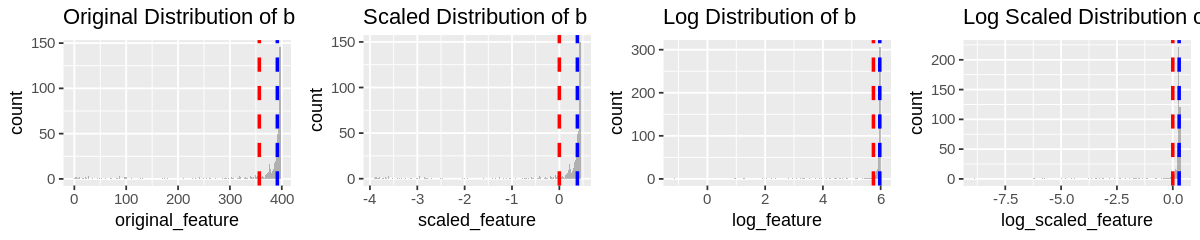

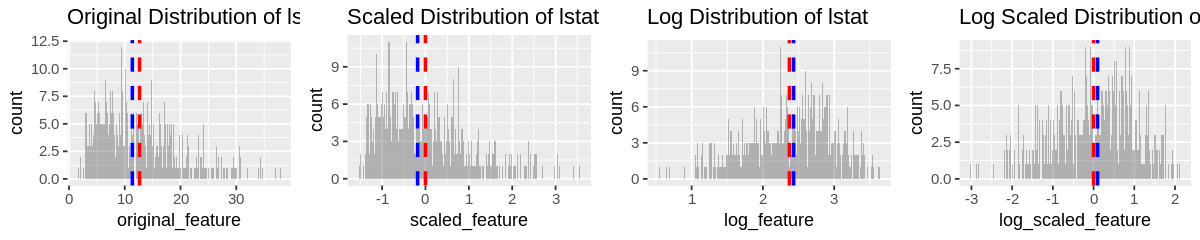

In [28]:
original_v_scaled_v_log('crim')
original_v_scaled_v_log('zn')
original_v_scaled_v_log('indus')
original_v_scaled_v_log('chas')
original_v_scaled_v_log('nox')
original_v_scaled_v_log('rm')
original_v_scaled_v_log('age')
original_v_scaled_v_log('dis')
original_v_scaled_v_log('rad')
original_v_scaled_v_log('tax')
original_v_scaled_v_log('ptratio')
original_v_scaled_v_log('b')
original_v_scaled_v_log('lstat')

#### Observations: 

For the plots above, it seems like after log there is a big improvement in the skews.


indus, rm, age, ptratio, b, lstat are negatively skewed or skewed to the left (mean is is lesser than the medium)

crim, zn, chas, nox, disn rad, tax are positively skewed or skewed to the right (mean is greater than the medium).

dis, rm, nox , lstat are skewed negligently.